In [1]:
import Clgw as clgw
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy.stats as st

Get GWB data

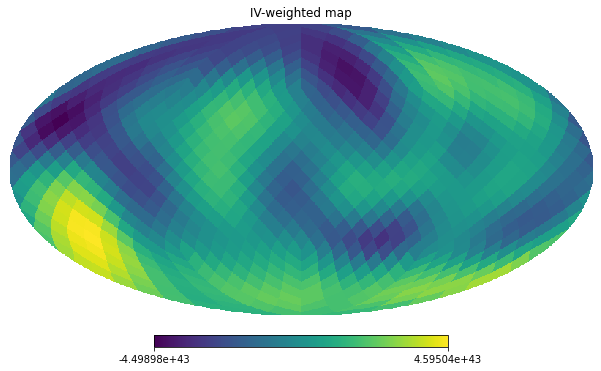

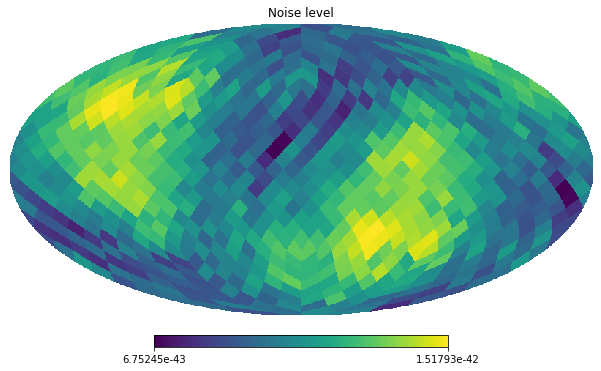

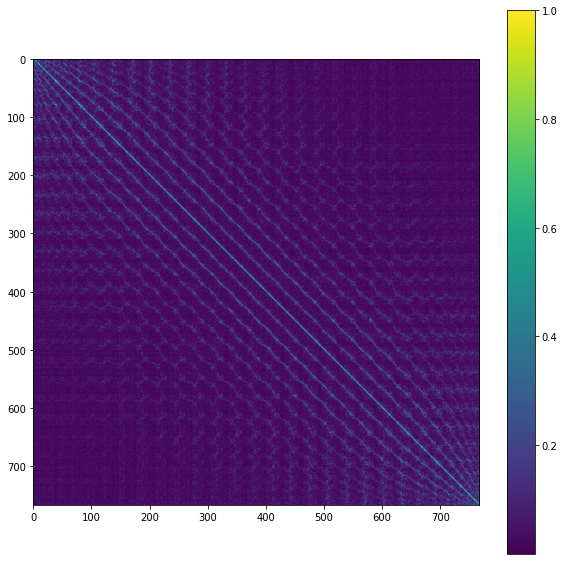

In [2]:
def get_GWB_data(npca=9):
    """ Returns the GWB data ready to be C_ell'd

    Arguments:
        npca (int): number of principal components to remove.

    Returns:
        iv_mp, inv_cov, noicov: inverse-variance-weighted map,
            corresponding inverse covariance to be used when
            computing power spectra, and noise covariance
    """
    d = np.load("GWB/GWB_covariance.npz")
    npol = 1
    nside = 8
    npix = hp.nside2npix(nside)
    ninv = np.real(np.swapaxes(d['M_p_pp'],1,2).reshape(npol*npix,
                                                        npol*npix))
    dirty_map = np.real(np.swapaxes(d['Z_p'],0,1)[0])
    imap, icov = clgw.get_IV_map(dirty_map, ninv, is_map_invw=True,
                                 is_cov_inv=True, nmode_map_remove=npca)
    ncov = np.linalg.inv(ninv)
    import scipy.linalg as la
    cov = la.pinv(icov, rcond=1E-5)
    hp.mollview(imap, title='IV-weighted map')
    hp.mollview(np.sqrt(np.diag(cov)), title='Noise level')
    plt.figure(figsize=(10, 10))
    plt.imshow(np.fabs(cov/np.sqrt(np.diag(cov)[None, :]*np.diag(cov)[:, None])))
    plt.colorbar()
    return imap, icov, ncov

ivm_w, icov_w, noicov_w = get_GWB_data()

Get galaxy data

In [3]:
def get_gal_data(fname_gal):
    """ Returns the galaxy data ready to be C_ell'd

    Arguments:
        fname_gal (str): path to data file.

    Returns:
        iv_mp, inv_cov: inverse-variance-weighted map and
            corresponding inverse covariance to be used when
            computing power spectra.
    """
    d = np.load(fname_gal)
    return clgw.get_IV_map(d['map'], d['inv_cov'], is_map_invw=False,
                           is_cov_inv=True, nmode_map_remove=0)

ivm_g, icov_g = get_gal_data("galaxies/data/map_cov_QSOs_smooth1p0_not_weighted.npz")

Get Q matrices

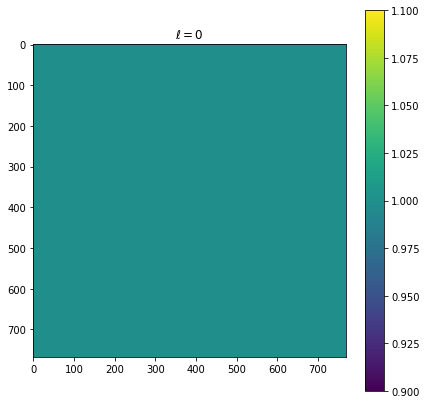

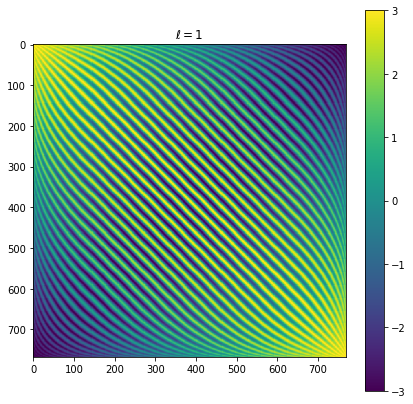

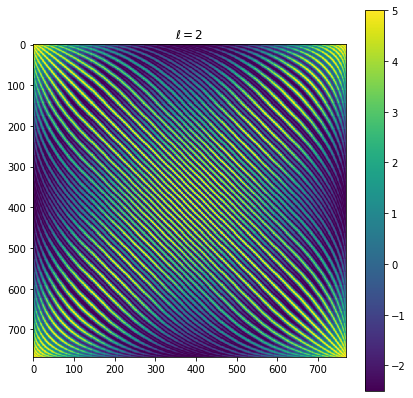

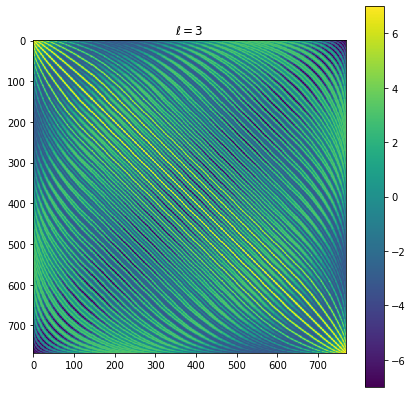

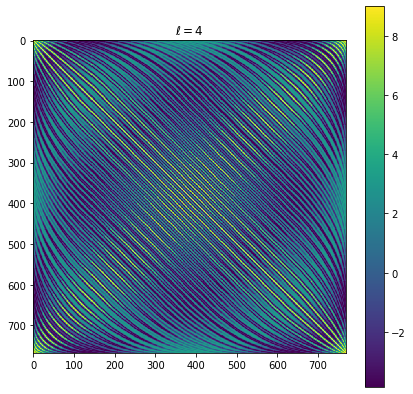

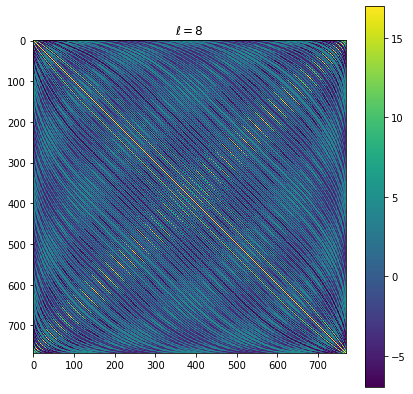

In [4]:
nside = 8
Qs = clgw.get_Q(nside)
for ell in [0, 1, 2, 3, 4, 8]:
    plt.figure(figsize=(7, 7))
    plt.title(f'$\\ell = {ell}$')
    plt.imshow(4*np.pi*Qs[ell], interpolation='nearest')
    plt.colorbar()

Get Fisher matrices (I'll do this for the GWB auto-corr and the x-corr)

In [5]:
d_ww = clgw.get_fisher_and_noise_bias(icov_w, noicov=noicov_w, Qmats=Qs)
d_gw = clgw.get_fisher_and_noise_bias(icov_w, invcov_2=icov_g, Qmats=None)

Compute pseudo-Cls

In [6]:
d_ww.update(clgw.get_pcl(ivm_w, Qmats=Qs))
d_gw.update(clgw.get_pcl(ivm_w, iv_map2=ivm_g, Qmats=Qs))

Put everything together. Preliminary errors just computed from the Fisher matrix

In [7]:
def get_cl_cov_from_dict(d):
    cov = np.linalg.inv(d['fisher'])
    cl = np.dot(cov, d['pcl_cl']-d['pcl_nl'])
    nl = np.dot(cov, d['pcl_nl'])
    return cl, cov, nl

cl_ww, cov_ww, nl_ww = get_cl_cov_from_dict(d_ww)
cl_gw, cov_gw, _ = get_cl_cov_from_dict(d_gw)

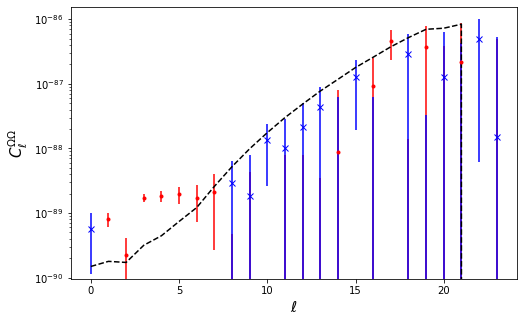

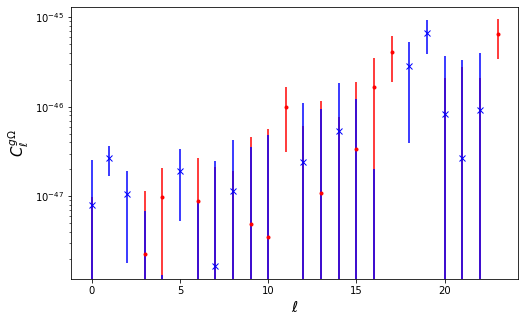

In [8]:
ls = np.arange(3*nside)

plt.figure(figsize=(8, 5))
plt.plot(ls, nl_ww, 'k--')
plt.errorbar(ls, cl_ww, yerr=np.sqrt(np.diag(cov_ww)), fmt='r.')
plt.errorbar(ls, -cl_ww, yerr=np.sqrt(np.diag(cov_ww)), fmt='bx')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C^{\Omega\Omega}_\ell$', fontsize=15)
plt.figure(figsize=(8, 5))
plt.errorbar(ls, cl_gw, yerr=np.sqrt(np.diag(cov_gw)), fmt='r.')
plt.errorbar(ls, -cl_gw, yerr=np.sqrt(np.diag(cov_gw)), fmt='bx')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C^{g\Omega}_\ell$', fontsize=15)
plt.show()

Generating galaxy mocks as Gaussian maps

In [9]:
d = np.load("galaxies/data/cl_QSOs_smooth1p0_not_weighted.npz")
ll = d['ls']
clgg = d['cl']
clgg_d = d['cl_data']
mask_hi = hp.read_map("galaxies/data/mask_QSOs_smooth1p0_not_weighted.fits.gz")
nside_hi = hp.npix2nside(mask_hi.size)

mask_thr = 0.7
mask_lo = hp.ud_grade(mask_hi, nside_out=nside)
pix_good = mask_lo > mask_thr
mask_binary_lo = np.ones_like(mask_lo)
mask_binary_lo[~pix_good] = 0
#delta_lo[pix_good] = delta_lo[pix_good]/mask_lo[pix_good]

In [10]:
def get_mock_gal_iv_map(use_data=True):
    """ Returns a mock IV-weighted galaxy overdensity map
    
    Returns:
        map
    """
    if use_data:
        cl_use = clgg_d
    else:
        cl_use = clgg
    delta_hi = hp.synfast(cl_use, nside_hi)
    delta_lo = hp.ud_grade(delta_hi*mask_hi, nside_out=nside)
    delta_lo[pix_good] = delta_lo[pix_good] / mask_lo[pix_good]
    delta_lo[~pix_good] = 0
    return delta_lo, np.dot(icov_g, delta_lo)

In [11]:
cl_sims = []
mp_sims = []
nsims = 500
for i in range(nsims):
    if i%50 == 0:
        print(i)
    dlo, mp_iv_g = get_mock_gal_iv_map()
    d = clgw.get_pcl(ivm_w, iv_map2=mp_iv_g, Qmats=Qs)
    cl_sims.append(np.dot(cov_gw, d['pcl_cl']))
    mp_sims.append(dlo)
cl_sims = np.array(cl_sims)
mp_sims = np.array(mp_sims)
cov_gw_sims = np.cov(cl_sims.T)

0
50
100
150
200
250
300
350
400
450


In [12]:
np.savez("galaxies/data/maps_sims_cov_QSOs_smooth1p0_not_weighted.npz",
         maps=mp_sims)

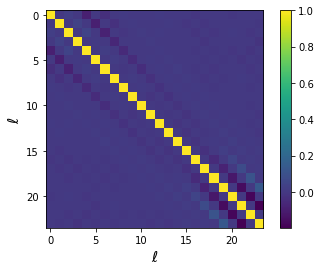

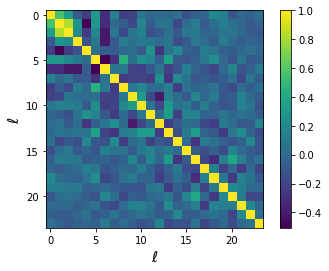

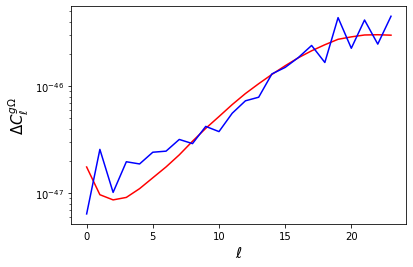

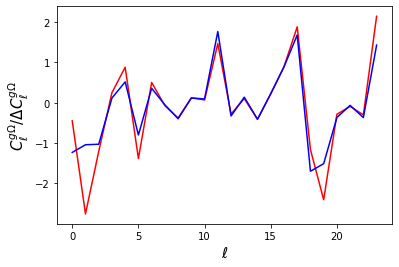

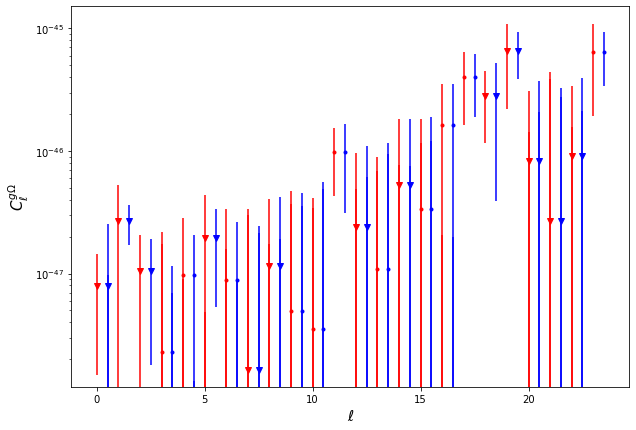

(16.395836710117763, 17, 0.4959672585036672)
(7.302858476527808, 17, 0.9792774034150784)


In [13]:
ls = np.arange(3*nside)


def rij(cov):
    return cov/np.outer(np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov)))

plt.figure()
plt.imshow(rij(cov_gw), interpolation='nearest')
plt.colorbar()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$\ell$', fontsize=15)

plt.figure()
plt.imshow(rij(cov_gw_sims), interpolation='nearest')
plt.colorbar()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$\ell$', fontsize=15)

plt.figure()
plt.plot(ls, np.sqrt(np.diag(cov_gw)), 'r-')
plt.plot(ls, np.sqrt(np.diag(cov_gw_sims)), 'b-')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$\Delta C^{g\Omega}_\ell$', fontsize=15)

plt.figure()
plt.plot(ls, cl_gw/np.sqrt(np.diag(cov_gw)), 'r-')
plt.plot(ls, cl_gw/np.sqrt(np.diag(cov_gw_sims)), 'b-')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell^{g\Omega}/\Delta C^{g\Omega}_\ell$', fontsize=15)

plt.figure(figsize=(10, 7))
plt.errorbar(ls, cl_gw, yerr=np.sqrt(np.diag(cov_gw_sims)), fmt='r.')
plt.errorbar(ls, -cl_gw, yerr=np.sqrt(np.diag(cov_gw_sims)), fmt='rv')
plt.errorbar(ls+0.5, cl_gw, yerr=np.sqrt(np.diag(cov_gw)), fmt='b.')
plt.errorbar(ls+0.5, -cl_gw, yerr=np.sqrt(np.diag(cov_gw)), fmt='bv')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C^{g\Omega}_\ell$', fontsize=15)
plt.show()

lgood = (ls <= 2*nside) & (ls >= 0)

def get_sn(cl, cov, is_diag=False):
    if is_diag:
        chi2 = np.sum(cl[lgood]**2/np.diag(cov)[lgood])
    else:
        chi2 = np.dot(cl[lgood], np.linalg.solve(cov[lgood][:, lgood], cl[lgood]))
    ndof = np.sum(lgood)
    pte = 1-st.chi2.cdf(chi2, ndof)
    return chi2, ndof, pte
print(get_sn(cl_gw, cov_gw))
print(get_sn(cl_gw, cov_gw_sims))